# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `25`
    * Students: `Erick Maraz`, `Lara Orlandic`, `Niccolo Stefanini`, `Valentin Viennot`

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Utils functions

In [2]:
def are_matrix_equals(a1, a2):
    if a1.shape != a2.shape:
        return False
    for index in np.ndindex(a1.shape):
        if a1[index] != a2[index]:
            return False
    return True

In [3]:
def array_map(f, *x):
    return np.array(list(map(f,*x)))

In [4]:
def is_matrix_symmetric(a):
    differences = np.count_nonzero(A_citation - A_citation.transpose())
    return differences == 0

In [5]:
def get_index_of_1D(array, element):
        i, = np.where(array == element)
        if len(i) == 0:
            return -1
        return i[0]

In [6]:
def prune_ids_adjacency_matrix(matrix, ids):
    """set to zeros rows/columns for given ids"""
    pruned = np.copy(matrix)
    for i in ids:
        pruned[i] = 0
        pruned[:,i] = 0
    return pruned

def reduce_ids_adjacency_matrix(matrix, ids):
    """only keeps given ids"""
    removed_ids = np.setdiff1d(range(matrix.shape[0]), ids)
    return reduce_ids_adjacency_matrix_removeids(matrix, removed_ids)

def reduce_ids_adjacency_matrix_removeids(matrix, ids):
    """only remove given ids"""
    pruned = np.delete(matrix, ids, axis=0)
    pruned = np.delete(pruned, ids, axis=1)
    return pruned

In [7]:
def unzip(zipped):
    return [ i for i, _ in zipped ], [ j for _, j in zipped ]

In [8]:
def clean_diagonal(matrix):
    np.fill_diagonal(matrix, 0)
    return matrix

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [9]:
features_names = ['w'+str(i) for i in range(1433)]
column_list = ['uid'] + features_names + ['class_label']
df = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list)
df.set_index('uid')
df.head()

,uid,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w1424,w1425,w1426,w1427,w1428,w1429,w1430,w1431,w1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [10]:
df.class_label.value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [11]:
my_field = 'Neural_Networks'
filtered_data = df[df.class_label == my_field]
features = filtered_data[features_names].values
features.shape

(818, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [12]:
def euclidean_distance_vectors(a, b):
    return np.linalg.norm(a-b)

def euclidean_distance_matrix(features_matrix):    
    matrix = [[euclidean_distance_vectors(a,b) for b in features_matrix] for a in features_matrix]
    return np.array(matrix)
    
distance = euclidean_distance_matrix(features)
distance.shape

(818, 818)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [13]:
mean_distance = distance.mean()
mean_distance

5.689638434824233

Plot an histogram of the euclidean distances.

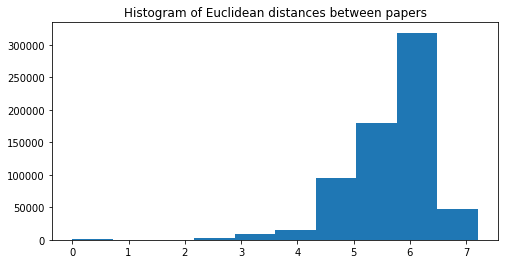

In [14]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [15]:
def binary_threshold_matrix(matrix, threshold):
    ''' returns a copy of the input matrix with values set to 1 if under threshold, 0 otherwise'''
    return np.where(matrix<threshold, 1, 0)

threshold = mean_distance
A_feature = clean_diagonal(binary_threshold_matrix(distance, threshold))
A_feature.shape

(818, 818)

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [16]:
def create_adjacency_matrix(edges, uids = None, directed = False):
    if uids is None:
        uids = np.unique(edges, axis=None)
    length = uids.shape[0]
    a = np.zeros((length,length))
    for edge in edges:
        id1 = get_index_of_1D(uids, edge[0])
        id2 = get_index_of_1D(uids, edge[1])
        if id1 == -1 or id2 == -1:
            continue
        a[id1,id2] = 1
        if not directed:
            a[id2,id1] = 1
    return a

cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')
A_citation_full = create_adjacency_matrix(cora_cites)
A_citation_full.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [17]:
filtered_uids = filtered_data['uid'].values
A_citation = create_adjacency_matrix(cora_cites, filtered_uids)
A_citation.shape

(818, 818)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [18]:
assert is_matrix_symmetric(A_citation) is True

np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [19]:
A_citation.shape

(818, 818)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [20]:
def count_edges(adjacency_matrix, directed = False):
    count = np.count_nonzero(adjacency_matrix)
    if directed:
        return count
    return count/2

num_edges_feature = count_edges(A_feature)
num_edges_citation = count_edges(A_citation)
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 136771.0
Number of edges in the citation graph: 1175.0


Plot the degree distribution histogram for each of the graphs.

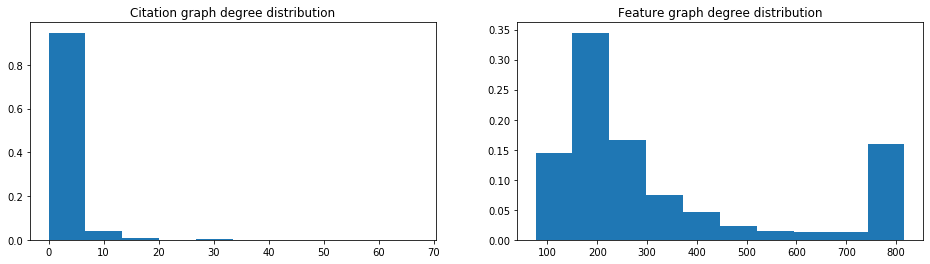

In [21]:
def compute_nodes_degrees(adjacency_matrix, directed = False):
    if directed:
        raise NotImplementedError
    return np.sum(adjacency_matrix, axis=0)

degrees_citation = compute_nodes_degrees(A_citation)
degrees_feature = compute_nodes_degrees(A_feature)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [22]:
def compute_nth_moment(adjacency_matrix, degree = 1, directed = False, center = 0):
    nodes_degrees = compute_nodes_degrees(adjacency_matrix, directed)
    nodes_degrees_t = array_map(lambda x: (x-center)**degree, nodes_degrees)
    return np.mean(nodes_degrees_t)

cit_moment_1 = compute_nth_moment(A_citation, 1)
cit_moment_2 = compute_nth_moment(A_citation, 2, center = cit_moment_1)

feat_moment_1 = compute_nth_moment(A_feature, 1)
feat_moment_2 = compute_nth_moment(A_feature, 2, center = feat_moment_1)

print(f"1st moment of citation graph: {cit_moment_1} (sqrt = {np.sqrt(cit_moment_1)})")
print(f"2nd moment of citation graph: {cit_moment_2} (sqrt = {np.sqrt(cit_moment_2)})")
print(f"1st moment of feature graph: {feat_moment_1} (sqrt = {np.sqrt(feat_moment_1)})")
print(f"2nd moment of feature graph: {feat_moment_2} (sqrt = {np.sqrt(feat_moment_2)})")

1st moment of citation graph: 2.8728606356968216 (sqrt = 1.6949515142613436)
2nd moment of citation graph: 15.511952941457784 (sqrt = 3.9385216695427467)
1st moment of feature graph: 334.4034229828851 (sqrt = 18.286700713438854)
2nd moment of feature graph: 55375.54874133943 (sqrt = 235.32009846449458)


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**    
The first moment is the average degree: It tells us how **dense** is the network (from **isolated nodes** (0) to a **complete graph** (number of nodes-1)).

We can use the second moment (variance) to assimilate the network to a **regular lattice** (variance == 0), **random network** (variance == sqrt(average_degree)) or **scale free network** (unbounded variance).
    
It is well represented with the degree distribution:    
1. Citation Graph: All nodes are about the same degree (low variance), and the graph is not very dense (low average), therefore it could be a random network, because the standard deviation is close to the average degree.
2. Feature Graph: There is a big variance because lots of node have a large degree (800) and many of them have a smaller one (around 200). It is probably because some big hubs exist in the graph. This implies that it could be a scale free network.

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

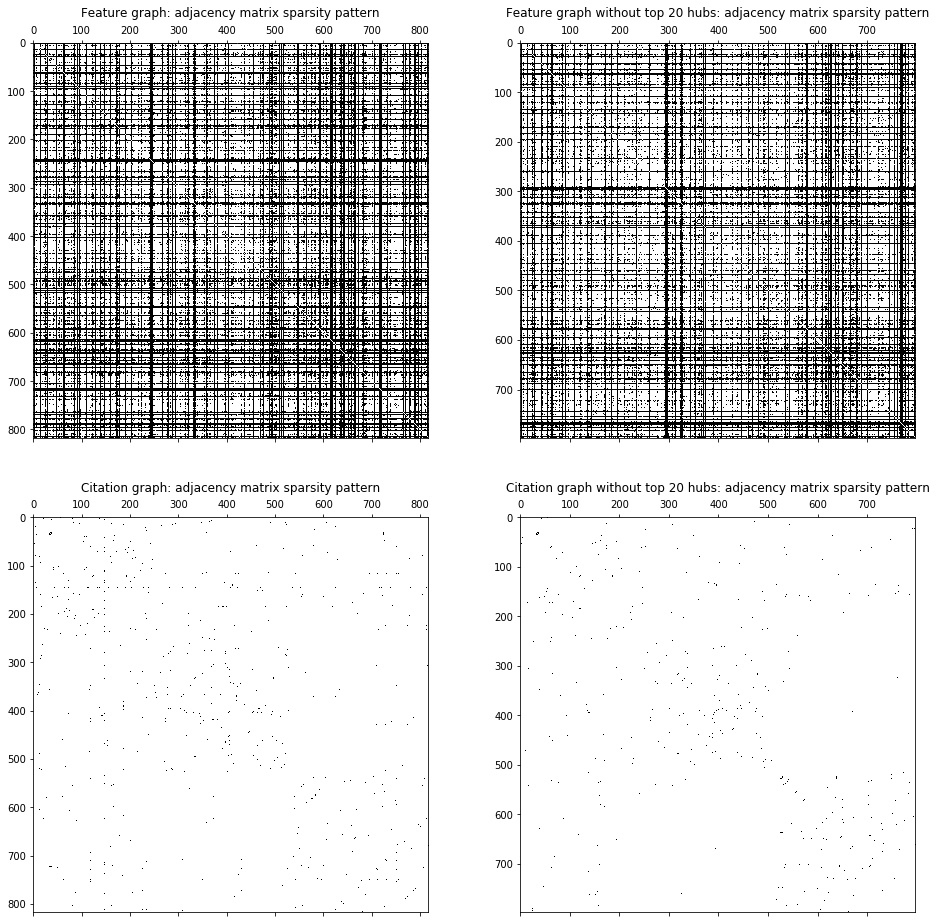

In [23]:
# TODO: 1. get the ids of the 20 largest hubs
# TODO: 2. prune the matrix of these ids
NUMBER_OF_HUBS = 20
ids_largest_hubs_citation = np.argpartition(degrees_citation, -NUMBER_OF_HUBS)[-NUMBER_OF_HUBS:]
ids_largest_hubs_feature = np.argpartition(degrees_feature, -NUMBER_OF_HUBS)[-NUMBER_OF_HUBS:]

reduced_A_feature = reduce_ids_adjacency_matrix_removeids(A_feature, ids_largest_hubs_feature)
reduced_A_citation = reduce_ids_adjacency_matrix_removeids(A_citation, ids_largest_hubs_citation)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

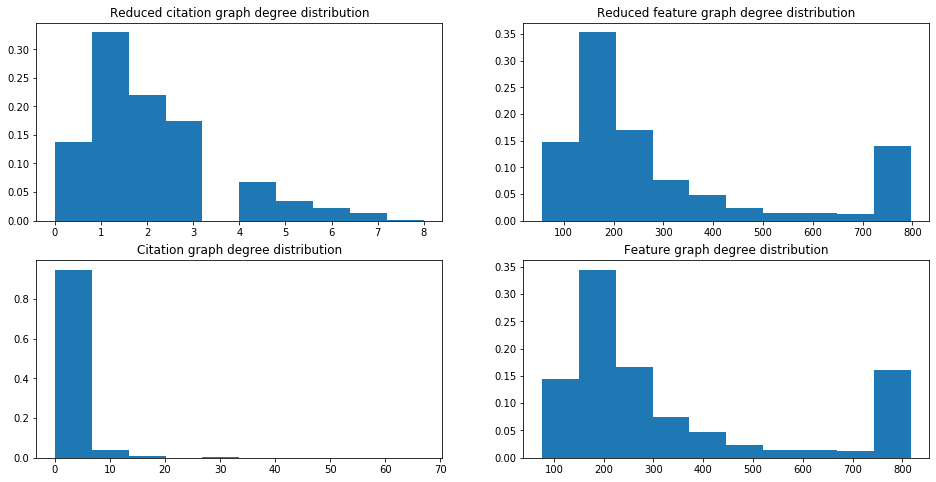

In [24]:
reduced_degrees_feat = compute_nodes_degrees(reduced_A_feature)
reduced_degrees_cit = compute_nodes_degrees(reduced_A_citation)

deg_hist_normalization_citation = np.ones(reduced_degrees_cit.shape[0])/reduced_degrees_cit.shape[0]
deg_hist_normalization_feature = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))
axes[0,0].set_title('Reduced citation graph degree distribution')
axes[0,0].hist(reduced_degrees_cit, weights=deg_hist_normalization_citation);
axes[0,1].set_title('Reduced feature graph degree distribution')
axes[0,1].hist(reduced_degrees_feat, weights=deg_hist_normalization_feature);

# recalling graphs distribution to compare more easily 
axes[1,0].set_title('Citation graph degree distribution')
axes[1,0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1,1].set_title('Feature graph degree distribution')
axes[1,1].hist(degrees_feature, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [25]:
reduced_cit_moment_1 = compute_nth_moment(reduced_A_citation, 1)
reduced_cit_moment_2 = compute_nth_moment(reduced_A_citation, 2, center = reduced_cit_moment_1)

reduced_feat_moment_1 = compute_nth_moment(reduced_A_feature, 1)
reduced_feat_moment_2 = compute_nth_moment(reduced_A_feature, 2, center = reduced_feat_moment_1)

print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.9724310776942355
Citation graph second moment: 2.3801923354752796
Feature graph first moment:  302.30827067669173
Feature graph second moment:  50780.035295004425


Print the number of edges in the reduced graphs.

In [26]:
num_edges_reduced_feature = count_edges(reduced_A_feature)
num_edges_reduced_citation = count_edges(reduced_A_citation)
print(f'Num edges in reduced feature={num_edges_reduced_feature}')
print(f'Num edges in reduced citation={num_edges_reduced_citation}')

Num edges in reduced feature=120621.0
Num edges in reduced citation=787.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

num_edges_feature varied by -11.808058725899496%
num_edges_citation varied by -33.02127659574468%
moment_1_citation varied by -31.34261184877087%
moment_2_citation varied by -84.65575324745927%
moment_1_feature varied by -9.597734383190213%
moment_2_feature varied by -8.29881337664167%


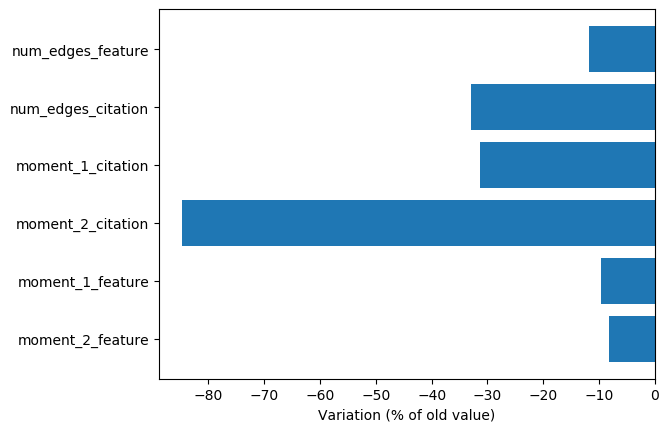

In [27]:
def show_variation(old_value, new_value, name = 'feature'):
    variation = (new_value-old_value)/old_value*100
    print('{} varied by {}%'.format(name, variation))
    return name, variation
variations_params = [
    (num_edges_feature, num_edges_reduced_feature, 'num_edges_feature'),
    (num_edges_citation, num_edges_reduced_citation, 'num_edges_citation'),
    (cit_moment_1, reduced_cit_moment_1, 'moment_1_citation'),
    (cit_moment_2, reduced_cit_moment_2, 'moment_2_citation'),
    (feat_moment_1, reduced_feat_moment_1, 'moment_1_feature'),
    (feat_moment_2, reduced_feat_moment_2, 'moment_2_feature')
]
variations = [show_variation(a,b,c) for a,b,c in variations_params]
x, heights = unzip(variations)

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(x))
ax.barh(y_pos, heights, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(x)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Variation (% of old value)')
plt.show()

**Your answer here:** It has more effect on the 2nd moment of the citation graph. Looking at the degree distribution, we can see that the citation graph has a few nodes with a very high degree. Removing them will decrease the variance significantly. On the other hand, the feature graph is less impacted because its degree distribution is more spread out and there are many nodes with high degrees, therefore removing only twenty of them will not significantly reduce the variance.

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [28]:
def dichotomic_search(min_param, max_param, expected_val, param_to_val, epsilon = 100, max_loops = 50):
    '''param_to_val should be a strctly increasing function of param on [min_param, max_param]'''
    test_param = (min_param+max_param)/2
    test_value = param_to_val(test_param)
    max_loops = max_loops - 1
    if max_loops == 0:
        print('WARNING: max_loops parameter exceeded -> dichotomic_search interrupted')
        return test_param
    if test_value < expected_val + epsilon and test_value > expected_val - epsilon:
        return test_param
    if test_value > expected_val:
        return dichotomic_search(min_param, test_param, expected_val, param_to_val, epsilon, max_loops)
    else:
        return dichotomic_search(test_param, max_param, expected_val, param_to_val, epsilon, max_loops)
    
threshold_2 = dichotomic_search(
    0,# zero is the lowest bound possible
    mean_distance,# we know that mean distance is already too much
    num_edges_citation,# that's our goal value (aka. number of edges in graph)
    lambda x: count_edges(clean_diagonal(binary_threshold_matrix(distance, x))),
    epsilon = 5
)
print("")
print(f"Optimal threshold is {threshold_2}")

A_feature_pruned = clean_diagonal(binary_threshold_matrix(distance, threshold_2))
num_edges_feature_pruned = count_edges(A_feature_pruned)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")


Optimal threshold is 2.828427124746193
Number of edges in the feature graph: 136771.0
Number of edges in the feature graph after pruning: 1386.0
Number of edges in the citation graph: 1175.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

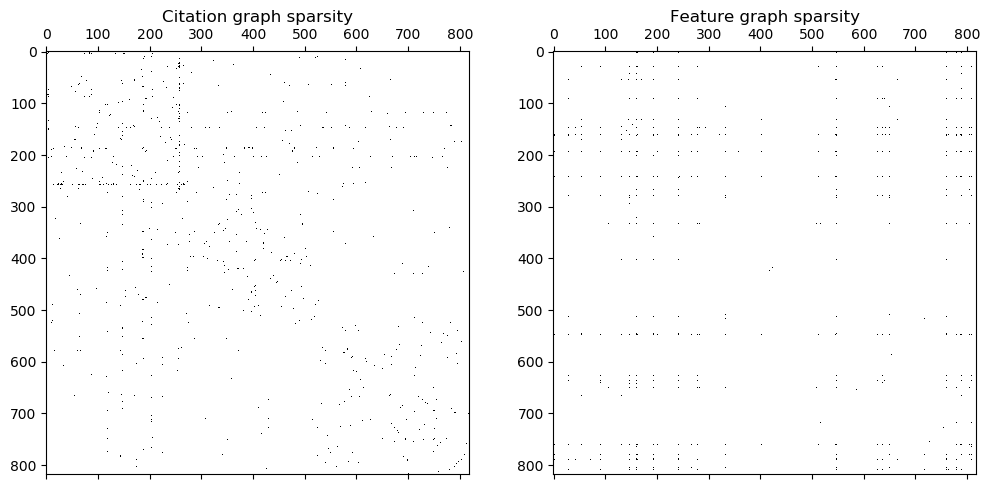

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [30]:
def compute_N_path_matrix(adjacency_matrix, N, next_n = 0, acc = None):    
    if acc is None:
        acc = np.zeros(adjacency_matrix.shape).astype('float64')
    else:
        acc = acc.astype('float64')
        
    mul = np.linalg.matrix_power(adjacency_matrix,0).astype('float64')
    
    for i in range(next_n, N+1):
        acc += mul
        mul = mul @ adjacency_matrix
    return acc

N = 10
path_matrix_citation = compute_N_path_matrix(A_citation, N)
path_matrix_feature = compute_N_path_matrix(A_feature, N)

Check the sparsity pattern for both of path matrices.

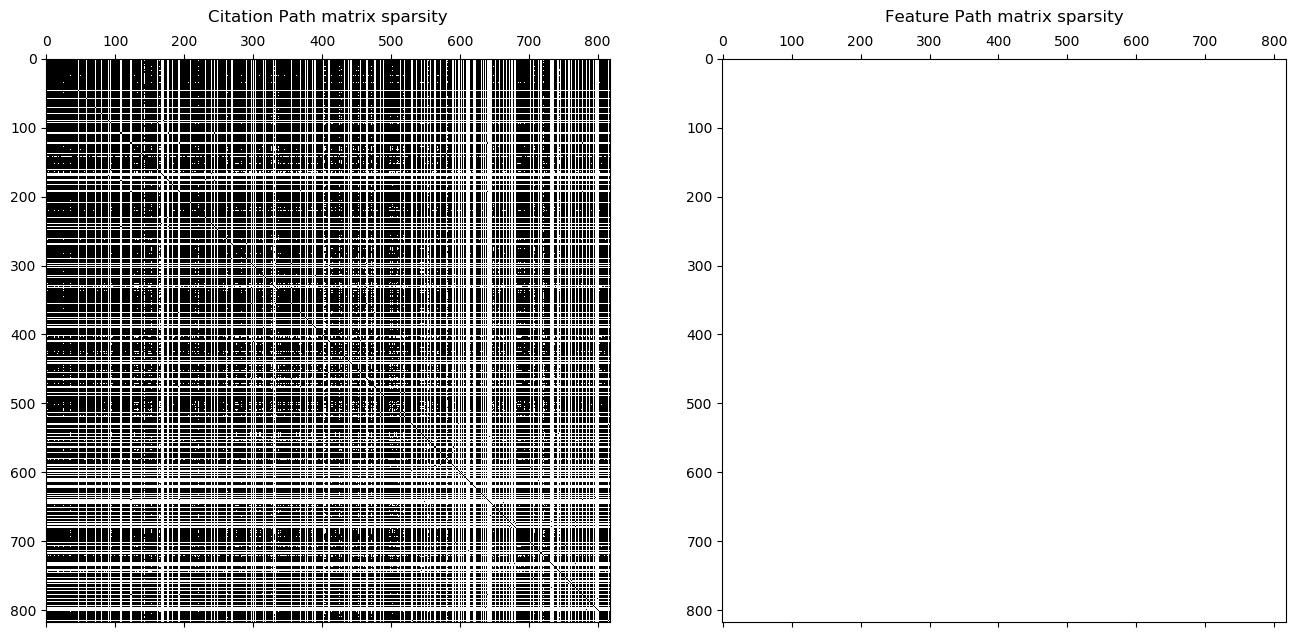

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

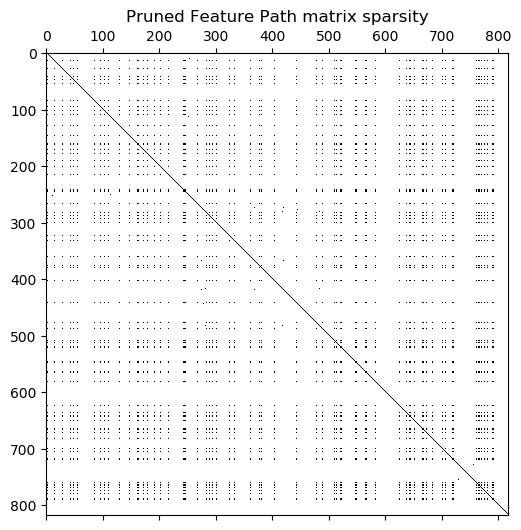

In [32]:
path_matrix_pruned = compute_N_path_matrix(A_feature_pruned, N)
plt.figure(figsize=(12, 6))
plt.title('Pruned Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:** The pruned feature path matrix has many fewer edges than the original feature graph, and therefore its path matrix is much more sparse, since it takes more steps to reach one node from another if there are fewer edges connecting them.

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** A graph is connected when there exists a path from any two nodes in the network, meaning that at some time up until the (N-1)th iteration of computing the path matrix, there are no zeros left in the path matrix because there exists at least one path from any two nodes in the network. The original feature graph is connected because at N=10, there are no more zeros left in the path matrix.

In [33]:
def get_matrix_connectivity(adjacency_matrix, N_max = 50, next_n = 0, output_logs = False):
    ''' returns -1 if not connected or the diameter if connected '''
    path_matrix = compute_N_path_matrix(adjacency_matrix, next_n)
    if np.count_nonzero(path_matrix==0) == 0:
        if output_logs:
            print(f"Matrix is connected with paths of max {next_n} step(s)")
        return next_n
    if next_n == N_max:
        if output_logs:
            print(f"Matrix is not connected")
            print(f"WARNING: connectivity has been checked for maximum {N_max}-step path")
        return -1
    return get_matrix_connectivity(adjacency_matrix, N_max, next_n + 1, output_logs)

def is_matrix_connected(adjacency_matrix, N_max = 50, next_n = 1, output_logs = False):
    return get_matrix_connectivity(adjacency_matrix, N_max, next_n, output_logs) != -1


print("Checking feature (unpruned) connectivity...")
is_matrix_connected(A_feature, output_logs = True)

Checking feature (unpruned) connectivity...
Matrix is connected with paths of max 2 step(s)


True

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:** The diameter of the graph is the lowest iteration of computing the path matrix at which there are no more zeros left in the path matrix, since this is equal to the maximum shortest path between nodes in the network.

If any of your graphs is connected, calculate the diameter using that process.

In [34]:
diameter = get_matrix_connectivity(A_feature)
print(f"The diameter is: {diameter}")

The diameter is: 2


Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [35]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

Diameter according to networkx: 2


## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [36]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [37]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 818, Number of edges: 1175
Number of self-loops: 0, Number of connected components: 104


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [38]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 818, Number of edges: 1386
Number of self-loops: 0, Number of connected components: 684


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [39]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

818

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [40]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

1280.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** This parameter describes the probability that two nodes in the graph are connected. Therefore, we divide the number of links by the total number of possible links in the network.

In [41]:
p = 2*m/(n*(n-1))
G_er = nx.erdos_renyi_graph(n, p, seed = 1) # we put a seed to be able to compare btw different notebooks

Check the number of edges in the Erdős–Rényi graph.

In [42]:
print('My Erdos-Rényi network has {} edges.'.format(G_er.size()))

My Erdos-Rényi network has 1284 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:** The preferential attachment parameter describes the number of edges to attach from a new node to existing nodes, which can be approximated by the number of edges per node in the network.

In [43]:
q = int(round(m/n))
G_ba = nx.barabasi_albert_graph(n, q, seed=1) # we put a seed to be able to compare btw different notebooks

Check the number of edges in the Barabási–Albert graph.

In [44]:
print('My Barabási-Albert network has {} edges.'.format(G_ba.size()))

My Barabási-Albert network has 1632 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [45]:
def get_giant_component(graph):
    Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)
    return Gcc[0]

In [46]:
giant_citation = get_giant_component(G_citation)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 636 nodes and 1079 edges.


In [47]:
giant_feature = get_giant_component(G_feature)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 117 nodes and 1364 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [48]:
giant_er = get_giant_component(G_er)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 773 nodes and 1279 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**     
Number of nodes in network (N): 818      
Wanted number of nodes in GC (Ng): 117      
That is to say N-Ng (= 701) nodes not in GC...      
We know that the probability for a node not to be in Gc is (1-p)^Ng      
So we should have N.(1-p)^Ng = N-Ng <=> p = 1-((N-Ng)/N)^(1/Ng)      
Finally, p = 0.0013183989472099755    

In [49]:
Ng = giant_feature.number_of_nodes()
N = n
print(f'Number of nodes in network (N): {N}')
print(f'Wanted number of nodes in GC (Ng): {Ng}')
print(f'That is to say N-Ng (= {N-Ng}) nodes not in GC...')
print(f'We know that the probability for a node not to be in Gc is (1-p)**Ng')
print(f'So we should have N*(1-p)**Ng = N-Ng <=> p = 1 - ((N-Ng)/N)**(1/Ng)')
p_new = 1 - ((N-Ng)/N)**(1/Ng)
print(f'Finally, p = {p_new}')

Number of nodes in network (N): 818
Wanted number of nodes in GC (Ng): 117
That is to say N-Ng (= 701) nodes not in GC...
We know that the probability for a node not to be in Gc is (1-p)**Ng
So we should have N*(1-p)**Ng = N-Ng <=> p = 1 - ((N-Ng)/N)**(1/Ng)
Finally, p = 0.0013183989472099755


Check the size of the new Erdős–Rényi network and its giant component.

In [50]:
G_er_new = nx.erdos_renyi_graph(n, p_new, seed = 1)
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = get_giant_component(G_er_new)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 424 edges.
The giant component of the new Erdos-Rényi network has 161 nodes and 161 edges.


### Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

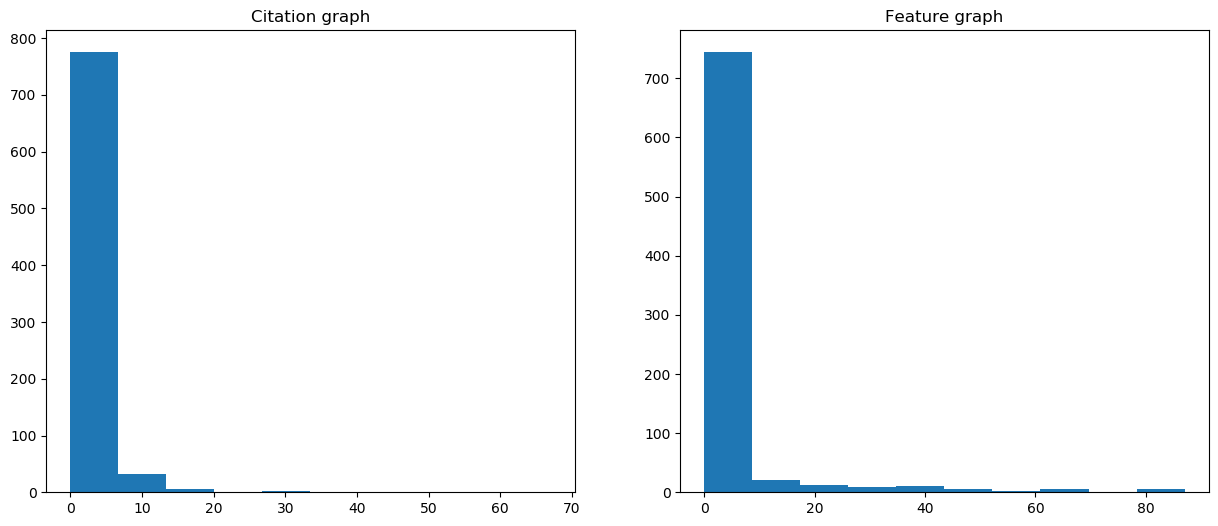

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = sorted([d for n, d in G_citation.degree()], reverse=True)
axes[0].hist(citation_degrees);
axes[1].set_title('Feature graph')
feature_degrees = sorted([d for n, d in G_feature.degree()], reverse=True) 
axes[1].hist(feature_degrees);

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:** The degree distribution shows us how many nodes in the network have a given degree, which then allows us to determine a network model we can use to estimate the degree distribution of our network. For example, the above graphs seem to follow a power law distribution because there are many nodes with very low degrees and a significant number of hubs with high degrees.

Now, plot the degree distribution histograms for the simulated networks.

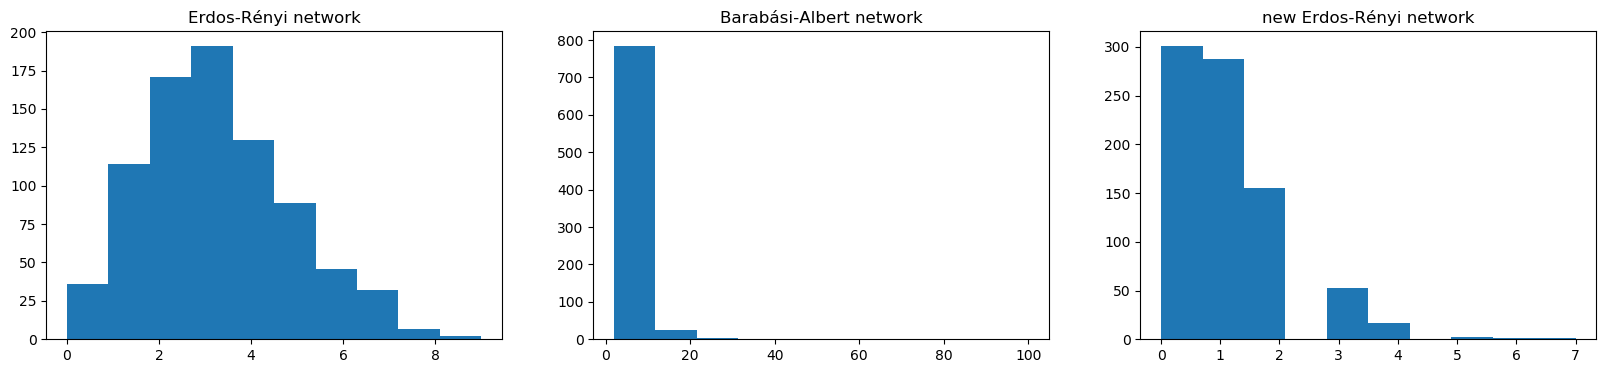

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [G_er.degree(n) for n in G_er.nodes()]
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [G_ba.degree(n) for n in G_ba.nodes()]
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [G_er_new.degree(n) for n in G_er_new.nodes()]
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** The best match to the feature and citation degree distribution graphs is the Barabasi-Albert network because they both have a high number of low-degree nodes and several high-degree hubs. The Erdos-Renyi graphs have a more Gaussian shape, which does not describe the degree distribution of our networks very well.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [53]:
G_config = nx.configuration_model([d for n, d in G_feature.degree()])
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))
#fig, axe = plt.subplots(figsize=(10, 4))
#axe.set_title('configuration model network')
#degrees = [G_config.degree(n) for n in G_config.nodes()]
#axe.hist(degrees);

Configuration model has 818 nodes and 1386 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** We do not create the same graph because a configuration model generates a random graph based on the degree distribution provided. Even though it may have the same number of nodes and edges as our graph, the edges are randomly placed among the nodes in a way that preserves the degree distribution, so the exact configuration of the graph is not preserved.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [54]:
p_citation = nx.average_clustering(G_citation)
p_citation

0.21693567980632222

In [55]:
nx.average_clustering(G_feature)

0.1220744470334593

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:** The clustering coefficient of a network is a value ranging from 0 to 1 that indicates what percentage of the neighbors of a given node are connected to each other. The low average clustering coefficients of our graphs imply that they are relatively unclustered. However, the citation graph coefficient is twice that of the feature graph. We could explain this difference by the existence of "citation clusters": papers that all cite each other. This should not be the case because citations in papers are constrained by the course of time; a paper must be published in order to be cited by another one. However, the fact that we built the citation graph as an undirected graph makes this phenomenon possible.

Now, let us check the average clustering coefficient for the simulated networks.

In [56]:
nx.average_clustering(G_er)

0.0006869251368028874

In [57]:
nx.average_clustering(G_ba)

0.029929824978549804

In [58]:
nx.average_clustering(nx.Graph(G_config))

0.05660122197369732

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:** The clustering coefficients of the simulated networks are all much lower than those of the citation and feature graphs, and there is no good match.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:** The Power Law Clusered Graph may give us a better match in terms of degree distribution and clusering coefficient because it allows us to keep the same power law distribution of the Barbarasi-Albert model, but incorporate a new parameter that allows us to emulate the clustering of the feature graph.

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

--- Test ---
Model has 818 nodes and 1632 edges.
Clustering coefficient is 0.19832867303607868
Self-loops: 0 - Connected components: 1
--- Citation graph ---
Model has 818 nodes and 1175 edges.
Clustering coefficient is 0.21693567980632222
Self-loops: 0 - Connected components: 104


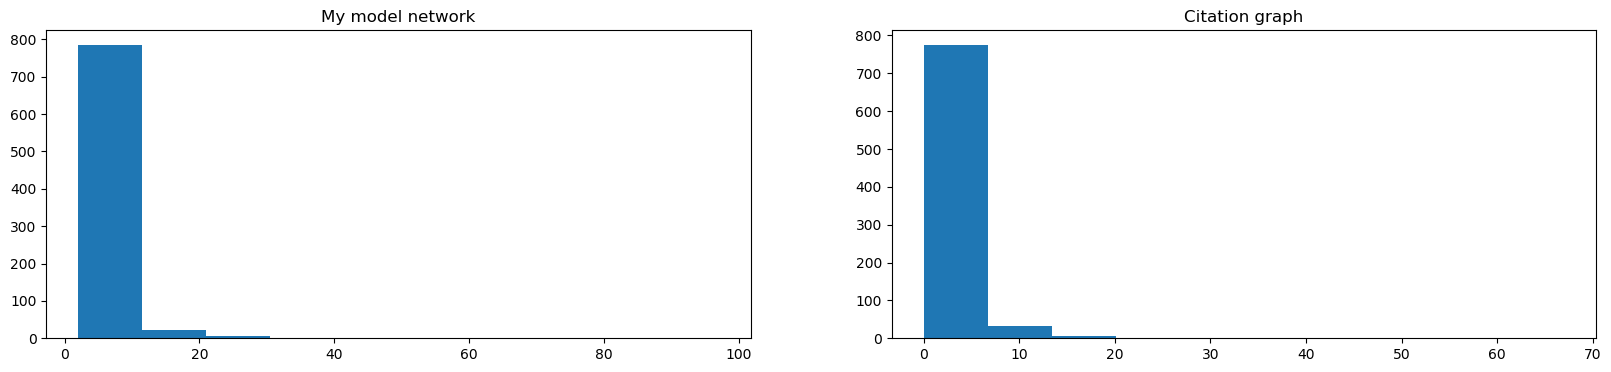

In [59]:
def print_graph_brief(graph, name='Test'):
    print(f'--- {name} ---')
    print(f'Model has {graph.number_of_nodes()} nodes and {graph.size()} edges.')
    print(f'Clustering coefficient is {nx.average_clustering(graph)}')
    print(f'Self-loops: {graph.number_of_selfloops()} - Connected components: {nx.number_connected_components(graph)}')

n_edges_citation = 2*G_citation.size() #undirected
average_edges_per_node = int(n_edges_citation/n)
G_test = nx.powerlaw_cluster_graph(n=n, m=average_edges_per_node, p=p_citation)

print_graph_brief(G_test)
print_graph_brief(G_citation, name='Citation graph')

fig, axes = plt.subplots(1, 2, figsize=(20, 4))
axes[0].set_title('My model network')
degrees = [G_test.degree(n) for n in G_test.nodes()]
axes[0].hist(degrees);
axes[1].set_title('Citation graph')
axes[1].hist(degrees_citation);

Comment on the similarities of your match.

**Your answer here:** The simulated degree distribution seems fairly similar to that of the original feature graph in that they both follow a power law distribution, but there seem to be fewer nodes with higher degrees than in the original graph.